# Esimate paramater for Normal distribution


In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

## preparing observation data


In [2]:
SAMPLE_SIZE = 100_000
MEAN = 10
SCALE = 3

# N(10, 9)
population = np.random.normal(MEAN, SCALE, SAMPLE_SIZE)
observation = population[np.random.randint(0, SAMPLE_SIZE, 1000)]
observation

array([ 8.15457284, 11.90171104,  9.5925449 ,  7.41949794,  6.43971289,
        6.07945104,  6.41467477,  8.56410532,  8.37231682, 12.61255561,
       13.13496134, 11.71191647, 10.23125733,  4.77519781, 13.79837389,
        6.32456673,  4.21746564,  5.91811012, 10.84540159,  6.74419435,
       13.7754467 , 11.77716396, 11.17319416,  9.82942581, 10.13917244,
        7.82854345,  9.90424948,  9.7169116 ,  8.79976632,  7.57423077,
       12.68499871,  7.21690106, 11.32552592, 13.32343175,  3.71278928,
        7.6900331 ,  9.85786684, 10.63106465, 11.62817726, 12.00884179,
       10.09844253,  8.94006548, 11.00504029,  8.38043255,  5.72311155,
       12.8881529 , 12.14319948, 13.94177052,  4.78712764,  5.13277414,
        5.53174725,  6.81339325,  5.22295419,  6.05559214,  9.97242278,
        4.34940409, 11.83197252,  8.44414605, 12.03992537,  9.59339262,
       15.11621861, 10.2437736 , 13.82456823,  7.82441475, 10.40010245,
        9.57623725,  9.0972248 ,  9.20766666,  7.25169646, 11.88

Text(0.5, 0, 'data')

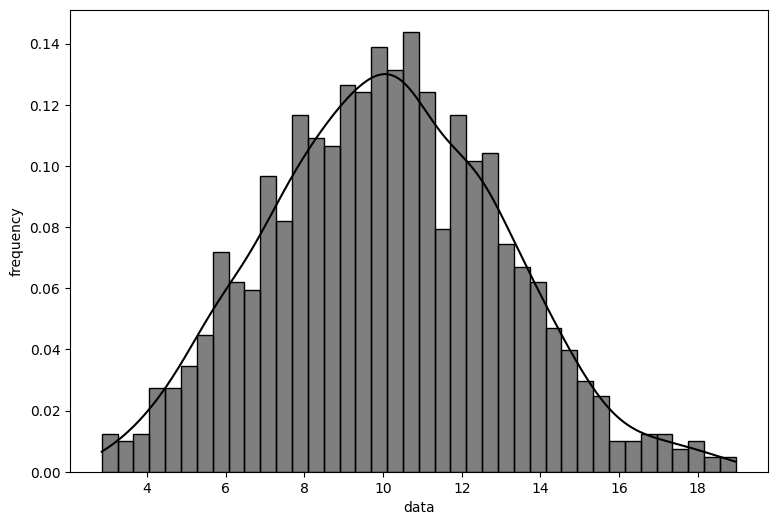

In [3]:
plt.figure(figsize=(9, 6))
sns.histplot(observation, color="k", stat="density", bins=40, kde=True)
plt.ylabel("frequency")
plt.xlabel("data")

In [4]:
print(f"Mean of observation data: {observation.mean()}")
print(f"std of observation data: {np.sqrt(observation.var())}")

Mean of observation data: 10.066803782367614
std of observation data: 2.9689402598657186


**NOTE:** Now we have to estimate the distribution. it looks like a normal distribution we have to find the parameter $\mu$ and $\sigma^2$


# Gibbs sampling


In [5]:
### Variables

## prior
# mu ~ N(mu0, sigma02)
mu0 = 10
sigma02 = 5

# sigm2 ~ INV-GAMMA(alpha, beta)
alpha = 2
beta = 18

# sigm2 ~ Scaled-INV-CHISQURE(v, sigma02) # degrees of fredom v -> 3 or 4 ( > 2) good choice
v = 4

### using inv gamma


In [6]:
sample = [
    [np.random.normal(mu0, np.sqrt(sigma02))],
    [1 / np.random.gamma(alpha, 1 / beta)],
]
for _ in range(SAMPLE_SIZE):
    current_sigma = sample[1][-1]
    mu_post_mean = (1 / ((1 / sigma02) + (len(observation) / current_sigma))) * (
        (mu0 / sigma02) + (observation.sum() / current_sigma)
    )
    mu_post_scale = (sigma02 * current_sigma) / (
        len(observation) * sigma02 + current_sigma
    )
    new_mu = np.random.normal(mu_post_mean, mu_post_scale)
    sigma_post_alpha = alpha + len(observation) / 2
    sigma_post_beta = beta + np.sum((observation - new_mu) ** 2) / 2
    new_sigma = 1 / np.random.gamma(sigma_post_alpha, 1 / sigma_post_beta)
    sample[0].append(new_mu)
    sample[1].append(new_sigma)

sample = np.array(sample)
sample

array([[ 5.86054361, 10.06593692, 10.05621611, ..., 10.0757538 ,
        10.05883223, 10.05295944],
       [14.8720135 ,  8.85085968,  8.43073017, ...,  8.69473383,
         8.70980038,  8.78445035]])

In [7]:
sample[0].mean()

10.066657267335822

In [8]:
np.sqrt(sample[1].mean())

2.9722962319725563

## using Scaled inverse chisqure


In [9]:
sample2 = [
    [np.random.normal(mu0, np.sqrt(sigma02))],
    [sigma02 * v / np.random.chisquare(v)],
]
for _ in range(SAMPLE_SIZE):
    current_sigma = sample2[1][-1]
    mu_post_mean = (1 / ((1 / sigma02) + (len(observation) / current_sigma))) * (
        (mu0 / sigma02) + (observation.sum() / current_sigma)
    )
    mu_post_scale = (sigma02 * current_sigma) / (
        len(observation) * sigma02 + current_sigma
    )
    new_mu = np.random.normal(mu_post_mean, mu_post_scale)
    sigma_post_df = v + len(observation)
    sigma_post_scale = (
        v * sigma02 + np.sum((observation - new_mu) ** 2)
    ) / sigma_post_df
    new_sigma = sigma_post_scale * sigma_post_df / np.random.chisquare(sigma_post_df)
    sample2[0].append(new_mu)
    sample2[1].append(new_sigma)

sample2 = np.array(sample2)
sample2

array([[  9.72127307,  10.3220412 ,  10.07199884, ...,  10.06472432,
         10.0564208 ,  10.07048087],
       [282.01207169,   8.74829011,   8.38080985, ...,   9.07907553,
          8.84735438,   8.72367454]])

In [10]:
sample2[0].mean()

10.066721171621946

In [11]:
np.sqrt(sample2[1].mean())

2.9696272779575357

## Comparism


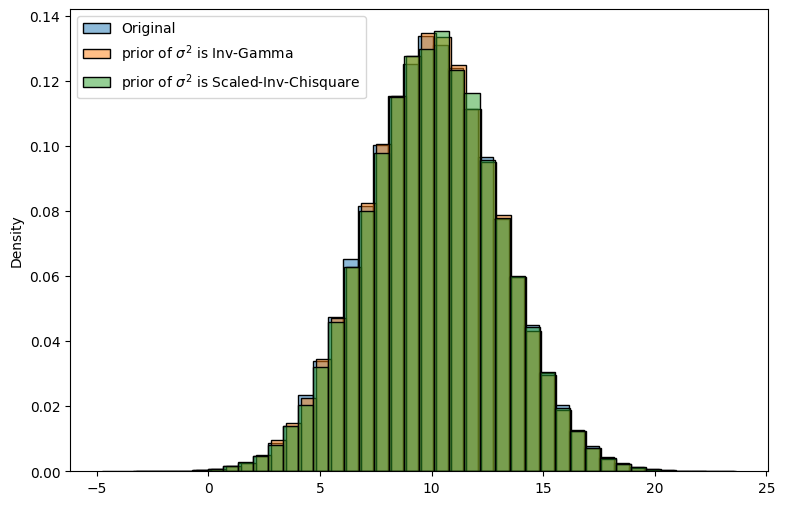

In [12]:
plt.figure(figsize=(9, 6))
sns.histplot(population, alpha=0.5, bins=40, label="Original", stat="density")
sns.histplot(
    np.random.normal(sample[0].mean(), np.sqrt(sample[1].mean()), SAMPLE_SIZE),
    alpha=0.5,
    bins=40,
    label=r"prior of $\sigma^2$ is Inv-Gamma",
    stat="density",
)
sns.histplot(
    np.random.normal(sample2[0].mean(), np.sqrt(sample2[1].mean()), SAMPLE_SIZE),
    alpha=0.5,
    bins=40,
    label=r"prior of $\sigma^2$ is Scaled-Inv-Chisquare",
    stat="density",
)
plt.legend()